# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [2]:
## Things to improve on:
# 1) Create more images so that the model isn't bias towards the more common images
# 2) Create more training data by reading Spatial Transformers Haloi
# 3) Create a condition for when to stop training to avoid overfitting by reading 
#    Joshua Bengio


---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
import numpy as np

### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = train['features'].shape[0]

# TODO: Number of testing examples.
n_test = test['features'].shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = train['features'].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(test['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

<Container object of 43 artists>

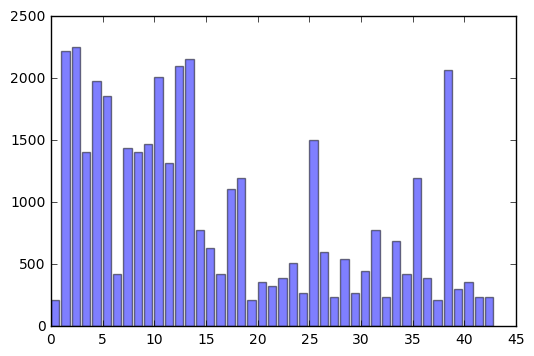

In [6]:
### Lets see the distribution of the images
counts_per_class = []
classes = range(n_classes)
for i in classes:
    count = (y_train == i).sum()
    counts_per_class.append(count)

y_pos = np.arange(n_classes)

plt.bar(y_pos, counts_per_class, alpha = 0.5)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
# First convert the RBG to YUV
def rgb2yuv(images_rbg):
        rgb2yuv_matrix = np.array([[0.299, 0.587, 0.114], [-0.1473, -0.28886, 0.436],[0.615, -0.51499, 0.10001]])
        return(np.tensordot(images_rbg, rgb2yuv_matrix, axes=([3], [1])))

In [8]:
X_train_yuv = rgb2yuv(X_train)
X_test_yuv = rgb2yuv(X_test)

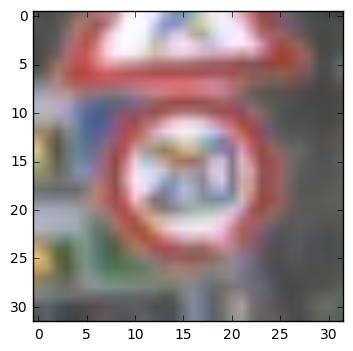

In [12]:
# Confirm that we did it correctly
# First plot the original image
plt.imshow(X_train[0], cmap = 'gray')

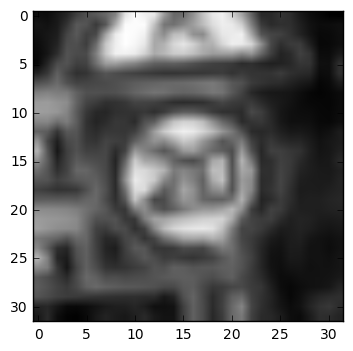

In [13]:
# Looks pretty good
plt.imshow(X_train_yuv[0][:,:,0], cmap='gray')

In [14]:
# Now normalize it by subtracting the mean and dividing by the variance
def normalize_image(images):
    
    
    # Get the YUV columns
    y_col = images[:,:,:,0]
    u_col = images[:,:,:,1]
    v_col = images[:,:,:,2]
    
    # Find the mean and sd
    y_mean = np.mean(y_col)
    u_mean = np.mean(u_col)
    v_mean = np.mean(v_col)
    y_sd = np.sqrt(np.var(y_col))
    u_sd = np.sqrt(np.var(u_col))
    v_sd = np.sqrt(np.var(v_col))
    
#     print("y_mean, u_mean, v_mean before normalization")
#     print(y_mean, u_mean, v_mean)
    
#     print("y_sd, u_sd, v_sd before normalization")
#     print(y_sd, u_sd, v_sd)
    
    images[:,:,:,0] = (images[:,:,:,0] - y_mean)/y_sd
    images[:,:,:,1] = (images[:,:,:,1] - u_mean)/u_sd
    images[:,:,:,2] = (images[:,:,:,2] - v_mean)/v_sd

    return(images)

In [15]:
# Normalize the YUV spaced images
X_train_yuv_normalize = normalize_image(X_train_yuv)
X_test_yuv_normalize = normalize_image(X_test_yuv)

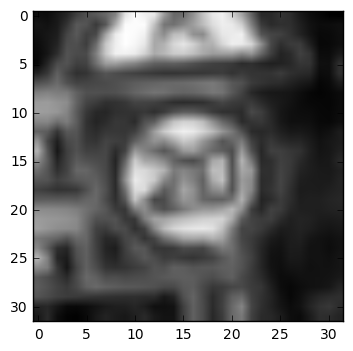

In [16]:
plt.imshow(X_train_yuv_normalize[0][:,:,0], cmap = 'gray')

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I preprocessed the data by first converting it to a YUV color space, and then standardizing it. The reason that I have done these preprocessing steps is 2-fold. The first being that converting to a YUV color space is because Y can be thought of as a grayscale image of the original image meaning that edges and other features are easier to be detected, but ontop of this, the U, and V scale also provide extra information compared to if we just converted the image to gray scale. The reason for standardizing the YUV values is because this will allow gradient descent to perform more effectively.

In [17]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many

# First lets split into a validation and train set

from sklearn.model_selection import train_test_split
X_train_yuv_normalize, X_validation_yuv_normalize, y_train, y_validation = train_test_split(X_train_yuv_normalize, y_train, test_size = 0.2)
print(X_train_yuv_normalize.shape)
print(X_validation_yuv_normalize.shape)
print(y_train.shape)
print(y_validation.shape) 

(31367, 32, 32, 3)
(7842, 32, 32, 3)
(31367,)
(7842,)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
As the data that we were provided has already been split into the train and testing part, all I really did was split the training set into a train and validation set.

# Defining the models

## LeNet

In [18]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    layer_depth = {
        'layer_1' : 32,
        'layer_2' : 64,
        'flatten' : 1600,
        'fc_1' : 120, 
        'fc_2' : 84,
        'logits' : 43
    }
    
    weights = {
        'layer_1' : tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_depth['layer_1']],mean = mu, stddev = sigma)),
        'layer_2' : tf.Variable(tf.truncated_normal(
        [5, 5, layer_depth['layer_1'], layer_depth['layer_2']],mean = mu, stddev = sigma)),
        'fc_1' : tf.Variable(tf.truncated_normal(
        [layer_depth['flatten'], layer_depth['fc_1']],mean = mu, stddev = sigma)),
        'fc_2' : tf.Variable(tf.truncated_normal(
        [layer_depth['fc_1'], layer_depth['fc_2']],mean = mu, stddev = sigma)),
        'logits' : tf.Variable(tf.truncated_normal(
        [layer_depth['fc_2'], layer_depth['logits']],mean = mu, stddev = sigma))
        
                                

        
    }
    
    biases = {
        'layer_1' : tf.Variable(tf.zeros(layer_depth['layer_1'])),
        'layer_2' : tf.Variable(tf.zeros(layer_depth['layer_2'])),
        'fc_1' : tf.Variable(tf.zeros(layer_depth['fc_1'])),
        'fc_2' : tf.Variable(tf.zeros(layer_depth['fc_2'])),
        'logits' : tf.Variable(tf.zeros(layer_depth['logits']))
    }
    
    
    # 5x5 convolution followed by a max pool
    conv1 = tf.nn.conv2d(x, weights['layer_1'], strides = [1,1,1,1], padding = "VALID")
    conv1 = tf.nn.bias_add(conv1, biases['layer_1'])
    conv1 = tf.nn.relu(conv1)       
    pool1 = tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = "VALID")

    # 5x5 convolution followed by a max pool
    conv2 = tf.nn.conv2d(pool1, weights['layer_2'], strides = [1,1,1,1], padding = "VALID")
    conv2 = tf.nn.bias_add(conv2, biases['layer_2'])
    conv2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1,2,2,1], padding = "VALID")

    # Reshape the network so that it can be fed to the fully connected layer
    flatten = tf.reshape(pool2, [-1, layer_depth['flatten']])

    # Fully connected layer 1
    fc_1 = tf.add(tf.matmul(flatten, weights['fc_1']), biases['fc_1'])
    fc_1 = tf.nn.dropout(tf.nn.relu(fc_1), keep_prob)

    # Fully connected layer 2
    fc_2 = tf.add(tf.matmul(fc_1, weights['fc_2']), biases['fc_2'])   
    fc_2 = tf.nn.relu(fc_2)

    # Predict the logits
    logits = tf.add(tf.matmul(fc_2, weights['logits']), biases['logits'])

    return logits

## Inception (but not really)

In [19]:
# Using the inception module
def create_weight(size, stddev = 0.1, Name = None):
    return tf.Variable(tf.truncated_normal(size, stddev), name = Name)

def inception(x):
    # Input is 32 x 32 x 3

    # First we have a inception layer

    # The inception layer consists of: 

    # - 1 1 x 1 convolution with depth 8 (layer_1_depth) 
    #   which we denote conv_1x1_ly1_1

    # - 1 1 x 1 convolution with depth 4 (layer_1_reduce) 
    #   which we denote conv_1x1_ly1_2
    #   followed by a 3 x 3 convolution with depth 8
    #   which we denote conv_3x3_ly1

    # - 1 1 x 1 convolution with depth 4 (layer_1_reduce) 
    #   which we denote conv_1x1_ly1_3
    #   followed by a 5 x 5 convolution with depth 8
    #   which we denote conv_5x5_ly1

    # - 1 3 x 3 max pooling with depth 3 (input_depth) 
    #   which we denote maxpool_3x3_ly1
    #   followed by a 1 x 1 convolution with depth 8
    #   which we denote conv_1x1_ly1_4

    # Then these layers are then concatenated 
    # Then we will end up with a concatenated layer ? x ? with depth 8

    # So we have 1 1 x 1 convolution
    input_depth = 3
    ly1_depth = 16 # this is the depth that each of the 
    ly1_reduce = 8 

    # 1 x 1 convolution with depth 16
    conv_1x1_ly1_1_W = create_weight([1, 1, input_depth, ly1_depth])
    conv_1x1_ly1_1_b = create_weight([ly1_depth])
    conv_1x1_ly1_1 = tf.nn.conv2d(x, conv_1x1_ly1_1_W, strides = [1,1,1,1], padding = "SAME") + conv_1x1_ly1_1_b
    print("conv_1x1_ly1_1.get_shape()")
    print(conv_1x1_ly1_1.get_shape())
    
    # 1 x 1 convolution with depth 8, followed by a 3 x 3 convolution with depth 8
    conv_1x1_ly1_2_W = create_weight([1, 1, input_depth, ly1_reduce])
    conv_1x1_ly1_2_b = create_weight([ly1_reduce])
    conv_1x1_ly1_2 = tf.nn.conv2d(x, conv_1x1_ly1_2_W, strides = [1,1,1,1], padding = "SAME") + conv_1x1_ly1_2_b

    # Hit it with a relu activation
    conv_1x1_ly1_2 = tf.nn.relu(conv_1x1_ly1_2)

    # Now follow this with a 3 x 3 convolution with depth 16
    conv_3x3_ly1_W = create_weight([3, 3, ly1_reduce, ly1_depth])
    conv_3x3_ly1_b = create_weight([ly1_depth])
    conv_3x3_ly1 = tf.nn.conv2d(conv_1x1_ly1_2, conv_3x3_ly1_W, strides = [1,1,1,1], padding = "SAME") + conv_3x3_ly1_b
    print("conv_3x3_ly1.get_shape()")
    print(conv_3x3_ly1.get_shape())
    
    # 1 x 1 convolution with depth 8, followed by a 5 x 5 convolution with depth 16
    conv_1x1_ly1_3_W = create_weight([1, 1, input_depth, ly1_reduce])
    conv_1x1_ly1_3_b = create_weight([ly1_reduce])
    conv_1x1_ly1_3 = tf.nn.conv2d(x, conv_1x1_ly1_3_W, strides = [1,1,1,1], padding = "SAME") + conv_1x1_ly1_3_b

    # Hit it with a relu activation
    conv_1x1_ly1_3 = tf.nn.relu(conv_1x1_ly1_3)

    # Now follow this up with a 5x5 with depth 16
    conv_5x5_ly1_W = create_weight([5,5, ly1_reduce, ly1_depth])
    conv_5x5_ly1_b = create_weight([ly1_depth])
    conv_5x5_ly1 = tf.nn.conv2d(conv_1x1_ly1_3, conv_5x5_ly1_W, strides = [1,1,1,1], padding = "SAME") + conv_5x5_ly1_b
    print("conv_5x5_ly1.get_shape()")
    print(conv_5x5_ly1.get_shape())
    
    
    # 3 x 3 max pooling followed by a 1 x 1 convolution with depth 16
    maxpool_3x3_ly1 = tf.nn.max_pool(x, ksize = [1,3,3,1], strides = [1,1,1,1], padding = "SAME")
    conv_1x1_ly1_4_W = create_weight([1,1,input_depth, ly1_depth])
    conv_1x1_ly1_4_b = create_weight([ly1_depth])
    conv_1x1_ly1_4 = tf.nn.conv2d(maxpool_3x3_ly1, conv_1x1_ly1_4_W, strides = [1,1,1,1], padding = "SAME") + conv_1x1_ly1_4_b
    print("conv_1x1_ly1_4.get_shape()")
    print(conv_1x1_ly1_4.get_shape())
    
    # Now concatenate the layers conv_1x1_ly1_1, conv_1x1_ly1_4, conv_3x3_ly1, conv_5x5_ly1
    inception_ly1 = tf.nn.relu(tf.concat(3, [conv_1x1_ly1_1, conv_3x3_ly1, conv_5x5_ly1, conv_1x1_ly1_4]))
    print("inception_ly1.get_shape()") 
    print(inception_ly1.get_shape())
        
    # Now for the second inception layer
    ly2_depth = 32 
    ly2_reduce = 8
                             
    # 1 x 1 convolution with depth 32
    conv_1x1_ly2_1_W = create_weight([1, 1, ly1_depth*4, ly2_depth])
    conv_1x1_ly2_1_b = create_weight([ly2_depth])
    conv_1x1_ly2_1 = tf.nn.conv2d(inception_ly1, conv_1x1_ly2_1_W, strides = [1,1,1,1], padding = "SAME") + conv_1x1_ly2_1_b
    print("conv_1x1_ly2_1.get_shape()")
    print(conv_1x1_ly2_1.get_shape())

    # 1 x 1 convolution with depth 8, followed by a 3 x 3 convolution with depth 32
    conv_1x1_ly2_2_W = create_weight([1, 1, ly1_depth*4, ly2_reduce])
    conv_1x1_ly2_2_b = create_weight([ly2_reduce])
    conv_1x1_ly2_2 = tf.nn.conv2d(inception_ly1, conv_1x1_ly2_2_W, strides = [1,1,1,1], padding = "SAME") + conv_1x1_ly2_2_b

    # Hit it with a relu activation
    conv_1x1_ly2_2 = tf.nn.relu(conv_1x1_ly2_2)

    # Now follow this with a 3 x 3 convolution with depth 32
    conv_3x3_ly2_W = create_weight([3, 3, ly2_reduce, ly2_depth])
    conv_3x3_ly2_b = create_weight([ly2_depth])
    conv_3x3_ly2 = tf.nn.conv2d(conv_1x1_ly2_2, conv_3x3_ly2_W, strides = [1,1,1,1], padding = "SAME") + conv_3x3_ly2_b
    print("conv_3x3_ly2.get_shape()")
    print(conv_3x3_ly2.get_shape())


    # 1 x 1 convolution with depth 8, followed by a 5 x 5 convolution with depth 32
    conv_1x1_ly2_3_W = create_weight([1, 1, ly1_depth*4, ly2_reduce])
    conv_1x1_ly2_3_b = create_weight([ly2_reduce])
    conv_1x1_ly2_3 = tf.nn.conv2d(inception_ly1, conv_1x1_ly2_3_W, strides = [1,1,1,1], padding = "SAME") + conv_1x1_ly2_3_b

    # Hit it with a relu activation
    conv_1x1_ly2_3 = tf.nn.relu(conv_1x1_ly2_3)

    # Now follow this up with a 5x5 with depth 32 
    conv_5x5_ly2_W = create_weight([5,5, ly2_reduce, ly2_depth])
    conv_5x5_ly2_b = create_weight([ly2_depth])
    conv_5x5_ly2 = tf.nn.conv2d(conv_1x1_ly2_3, conv_5x5_ly2_W, strides = [1,1,1,1], padding = "SAME") + conv_5x5_ly2_b
    print("conv_5x5_ly2.get_shape()")
    print(conv_5x5_ly2.get_shape())
    
    # 3 x 3 max pooling followed by a 1 x 1 convolution with depth 32
    maxpool_3x3_ly2 = tf.nn.max_pool(inception_ly1, ksize = [1,3,3,1], strides = [1,1,1,1], padding = "SAME")
    conv_1x1_ly2_4_W = create_weight([1,1,ly1_depth*4, ly2_depth])
    conv_1x1_ly2_4_b = create_weight([ly2_depth])
    conv_1x1_ly2_4 = tf.nn.conv2d(maxpool_3x3_ly2, conv_1x1_ly2_4_W, strides = [1,1,1,1], padding = "SAME") + conv_1x1_ly2_4_b
    print("conv_1x1_ly2_4.get_shape()")
    print(conv_1x1_ly2_4.get_shape())
    

    # Now concatenate the layers conv_1x1_ly2_1, conv_1x1_ly2_4, conv_3x3_ly2, conv_5x5_ly2
    inception_ly2 = tf.nn.relu(tf.concat(3, [conv_1x1_ly2_1, conv_1x1_ly2_4, conv_3x3_ly2, conv_5x5_ly2]))
    print("inception_ly2.get_shape()")
    print(inception_ly2.get_shape())
    
    # Now use the fully connected layers inception_ly2 output is 
    # 32 * 32 (for the image sizes) 
    #    * 4 (as we are concatenating 4 layers) 
    #    * ly2_depth (which is the depth of layer 2)
        
    inception_ly2_flatten = tf.reshape(inception_ly2, [-1, 32*32*4*ly2_depth])
                               
    # Number of nodes in the next fully connected layer
    fc_1_width = 700 
    fc_1_W = create_weight([32 * 32 * 4 * ly2_depth, fc_1_width])
    fc_1_b = create_weight([fc_1_width])
    fc_1 = tf.matmul(inception_ly2_flatten,fc_1_W) + fc_1_b
    fc_1 = tf.nn.relu(fc_1)
     
    fc_2_width = 43 # the number of outputs
    fc_2_W = create_weight([fc_1_width, fc_2_width])
    fc_2_b = create_weight([fc_2_width])
    logits = tf.matmul(fc_1, fc_2_W) + fc_2_b
    return logits               
                               

# LeNet with Spatial Transform

In [20]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import tensorflow as tf


def transformer(U, theta, out_size, name='SpatialTransformer', **kwargs):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Based on [2]_ and edited by David Dao for Tensorflow.
    Parameters
    ----------
    U : float
        The output of a convolutional net should have the
        shape [num_batch, height, width, num_channels].
    theta: float
        The output of the
        localisation network should be [num_batch, 6].
    out_size: tuple of two ints
        The size of the output of the network (height, width)
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    Notes
    -----
    To initialize the network to the identity transform init
    ``theta`` to :
        identity = np.array([[1., 0., 0.],
                             [0., 1., 0.]])
        identity = identity.flatten()
        theta = tf.Variable(initial_value=identity)
    """

    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.transpose(
                tf.expand_dims(tf.ones(shape=tf.pack([n_repeats, ])), 1), [1, 0])
            rep = tf.cast(rep, 'int32')
            x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
            return tf.reshape(x, [-1])

    def _interpolate(im, x, y, out_size):
        with tf.variable_scope('_interpolate'):
            # constants
            num_batch = tf.shape(im)[0]
            height = tf.shape(im)[1]
            width = tf.shape(im)[2]
            channels = tf.shape(im)[3]

            x = tf.cast(x, 'float32')
            y = tf.cast(y, 'float32')
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            zero = tf.zeros([], dtype='int32')
            max_y = tf.cast(tf.shape(im)[1] - 1, 'int32')
            max_x = tf.cast(tf.shape(im)[2] - 1, 'int32')

            # scale indices from [-1, 1] to [0, width/height]
            x = (x + 1.0)*(width_f) / 2.0
            y = (y + 1.0)*(height_f) / 2.0

            # do sampling
            x0 = tf.cast(tf.floor(x), 'int32')
            x1 = x0 + 1
            y0 = tf.cast(tf.floor(y), 'int32')
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, zero, max_x)
            x1 = tf.clip_by_value(x1, zero, max_x)
            y0 = tf.clip_by_value(y0, zero, max_y)
            y1 = tf.clip_by_value(y1, zero, max_y)
            dim2 = width
            dim1 = width*height
            base = _repeat(tf.range(num_batch)*dim1, out_height*out_width)
            base_y0 = base + y0*dim2
            base_y1 = base + y1*dim2
            idx_a = base_y0 + x0
            idx_b = base_y1 + x0
            idx_c = base_y0 + x1
            idx_d = base_y1 + x1

            # use indices to lookup pixels in the flat image and restore
            # channels dim
            im_flat = tf.reshape(im, tf.pack([-1, channels]))
            im_flat = tf.cast(im_flat, 'float32')
            Ia = tf.gather(im_flat, idx_a)
            Ib = tf.gather(im_flat, idx_b)
            Ic = tf.gather(im_flat, idx_c)
            Id = tf.gather(im_flat, idx_d)

            # and finally calculate interpolated values
            x0_f = tf.cast(x0, 'float32')
            x1_f = tf.cast(x1, 'float32')
            y0_f = tf.cast(y0, 'float32')
            y1_f = tf.cast(y1, 'float32')
            wa = tf.expand_dims(((x1_f-x) * (y1_f-y)), 1)
            wb = tf.expand_dims(((x1_f-x) * (y-y0_f)), 1)
            wc = tf.expand_dims(((x-x0_f) * (y1_f-y)), 1)
            wd = tf.expand_dims(((x-x0_f) * (y-y0_f)), 1)
            output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
            return output

    def _meshgrid(height, width):
        with tf.variable_scope('_meshgrid'):
            # This should be equivalent to:
            #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
            #                         np.linspace(-1, 1, height))
            #  ones = np.ones(np.prod(x_t.shape))
            #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
            x_t = tf.matmul(tf.ones(shape=tf.pack([height, 1])),
                            tf.transpose(tf.expand_dims(tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
            y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                            tf.ones(shape=tf.pack([1, width])))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            ones = tf.ones_like(x_t_flat)
            grid = tf.concat(0, [x_t_flat, y_t_flat, ones])
            return grid

    def _transform(theta, input_dim, out_size):
        with tf.variable_scope('_transform'):
            num_batch = tf.shape(input_dim)[0]
            height = tf.shape(input_dim)[1]
            width = tf.shape(input_dim)[2]
            num_channels = tf.shape(input_dim)[3]
            theta = tf.reshape(theta, (-1, 2, 3))
            theta = tf.cast(theta, 'float32')

            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            grid = _meshgrid(out_height, out_width)
            grid = tf.expand_dims(grid, 0)
            grid = tf.reshape(grid, [-1])
            grid = tf.tile(grid, tf.pack([num_batch]))
            grid = tf.reshape(grid, tf.pack([num_batch, 3, -1]))

            # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
            T_g = tf.batch_matmul(theta, grid)
            x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
            x_s_flat = tf.reshape(x_s, [-1])
            y_s_flat = tf.reshape(y_s, [-1])

            input_transformed = _interpolate(
                input_dim, x_s_flat, y_s_flat,
                out_size)

            output = tf.reshape(
                input_transformed, tf.pack([num_batch, out_height, out_width, num_channels]))
            return output

    with tf.variable_scope(name):
        output = _transform(theta, U, out_size)
        return output

In [23]:
def LeNet_with_spatial_transform(x, keep_prob):
        
    # First build the localization layers 
    
    # First max pool
    loc_1 = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding = "SAME")
    print("loc_1.get_shape()")
    print(loc_1.get_shape())
   
    # Followed by a conv layer
    loc_2_depth = 8
    loc_2_W = tf.Variable(tf.truncated_normal([5, 5, 3, loc_2_depth], stddev = 0.1))
    loc_2_b = tf.Variable(tf.zeros([loc_2_depth]))
    loc_2 = tf.nn.conv2d(loc_1, loc_2_W, strides = [1, 1, 1, 1], padding = "SAME") + loc_2_b
    loc_2 = tf.nn.relu(loc_2)
    print("loc_2.get_shape()")
    print(loc_2.get_shape())
     
    # Followed by another max pool
    loc_3 = tf.nn.max_pool(loc_2, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding = "SAME")
    print("loc_3.get_shape()")
    print(loc_3.get_shape())
    
    # Followed by another conv layer 
    loc_4_depth = 8
    loc_4_W = tf.Variable(tf.truncated_normal([5, 5, loc_2_depth, loc_4_depth], stddev = 0.1))
    loc_4_b = tf.Variable(tf.zeros([loc_4_depth]))
    loc_4 = tf.nn.conv2d(loc_3, loc_4_W, strides = [1, 1, 1, 1], padding = "SAME") + loc_4_b
    loc_4 = tf.nn.relu(loc_4)
    print("loc_4.get_shape()")
    print(loc_4.get_shape())
    
    loc_4_flatten_n = 32 * 32 * loc_4_depth
    loc_4_flatten = tf.reshape(loc_4, [-1, loc_4_flatten_n])
    print("loc_4_flatten.get_shape()")
    print(loc_4_flatten.get_shape())
    
    # Followed by a regression layer
    loc_5_width = 50
    loc_5_W = tf.Variable(tf.truncated_normal([loc_4_flatten_n, loc_5_width], stddev = 0.1)) 
    loc_5_b = tf.Variable(tf.zeros([loc_5_width]))
    loc_5 = tf.matmul(loc_4_flatten, loc_5_W) + loc_5_b
    loc_5 = tf.nn.relu(loc_5)
    print("loc_5.get_shape()")
    print(loc_5.get_shape())
    
    # Finally predict the variables for the affine transform
    loc_out_n = 6 # for the 6 variables in the affine transform
    
    # Note here that we are setting the weight matrix to zero so that before the first update
    # there is no affine transform
    loc_out_W = tf.Variable(tf.zeros([loc_5_width, loc_out_n])) 
    
    # Define the initial affine transform matrix
    identity = np.array([[1.,0.,0.], [0.,1.,0.]])
    identity = identity.astype('float32')
    identity = identity.flatten()
    
    # The identity matrix so that the matrix can learn  
    initial_identity = tf.Variable(initial_value = identity)
    
   
    # Note here that U is the 
    # Finally define the final affine transform
    theta = tf.matmul(loc_5, loc_out_W) + initial_identity
    print("theta.get_shape()")
    print(theta.get_shape())
    
    # Now use the transformation module in tensorflow
    V = transformer(x, theta, (32, 32))
#     print("V.get_shape()")
#     print(V.get_shape())
    V.set_shape([None, 32, 32, 3])
#     print("V.get_shape()")
#     print(V.get_shape())
    
    # Pass this into Lenet
    logits = LeNet(V, keep_prob)
    return(logits)
    
    

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Below is the architecture that I have used for my prediction of the test set:
   
    # Spatial transformer (data first goes in here, the goal is to find an affine transform
                           which helps the neural network classify)
    
    layer 1: max pool
    32x32x3 -> 32x32x3
    ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding = SAME
    
    layer 2: convolution with 5x5 convolution
    32x32x3 -> 32x32x8
    strides = [1, 1, 1, 1], padding = same, filter = 8
    activation = RELU
    
    layer 3: max pool
    32x32x8 -> 32x32x8
    ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding = SAME
    
    layer 4: convolution with 5x5 convolution
    32x32x8 -> 32x32x8
    strides = [1, 1, 1, 1], padding = same, filter = 8
    activation = RELU
       
    layer 5: flatten
    32x32x8 -> 8192x1
    
    layer 6: fully connected
    8192x1 -> 50x1
    
    layer 7: fully connected
    50x1 -> 6x1 (as we need 6 parameters for the affine transform matrix)
    NOTE HERE: that the bias vector is not set to 0, but rather:
    
    T = [1, 0, 0]
        [0, 1, 0]
    
    ALSO: the weight vector is initialized to 0, so that before the first update, the 
          neural network is getting fed the original data
          
  
    
    Now we apply an affine transform T to the input so: V = T(x) where x is the input
    
    Now we feed x into the layer 1 of our Convolution Neural Network
 
    # Convolution Neural Network
    layer 1: convolution with 5x5 convolution
    32x32x3 -> 28x28x32
    strides = [1, 1, 1, 1], padding = VALID, filter = 32
    activation = RELU
    
    layer 2: max pool
    28x28x32 -> 14x14x32
    ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = VALID
    
    layer 3: convolution with 5x5 convolution
    14x14x32 -> 10x10x64
    strides = [1, 1, 1, 1], padding = VALID, filter = 64
    activation = RELU
    
    layer 4: max pool
    10x10x64 -> 5x5x64
    ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = VALID

    layer 5: flatten
    5x5x64 -> 1600x1
    
    layer 6: fully connected
    1600x1 -> 120x1
    
    layer 7: fully connected
    120 x 1 -> 84x1
    
    batch_size = 64
    epochs = 20
    learning rate : 1e-3
    weights ~ N(0, 0.1^2)
    bias were initalized to 0
    optimizer used was the Adam Optimizer
    
    Validation accuracy caps at around 99.04% with 20 epochs
    Test accuracy is at around 93.65%

In [24]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Define the place holders
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

# Turn into 1 hot representation
one_hot_y = tf.one_hot(y, 43)

# Define the learning rate
rate = 1e-3

# Define the neural network graph
logits = LeNet_with_spatial_transform(x, keep_prob)

# Define loss function
softmax = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

loc_1.get_shape()
(?, 32, 32, 3)
loc_2.get_shape()
(?, 32, 32, 8)
loc_3.get_shape()
(?, 32, 32, 8)
loc_4.get_shape()
(?, 32, 32, 8)
loc_4_flatten.get_shape()
(?, 8192)
loc_5.get_shape()
(?, 50)
theta.get_shape()
(?, 6)


In [25]:
# Helper function for evaluation
def evaluate(X_data, y_data):
    num_examples = len(X_data)
#     print("Number of examples in X_validation_yuv_normalize")
#     print(num_examples)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
#         print("batch_x.shape")
#         print(batch_x.shape)
#         print("batch_y.shape")
#         print(batch_y.shape)
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1})
#         accuracy = accuracy_operation.eval(feed_dict={x: batch_x, y: batch_y, keep_prob : 1})
#         print("accuracy is:")
#         print(accuracy)
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [33]:
# Now finally start the training
from sklearn.utils import shuffle
import os
EPOCHS = 5
BATCH_SIZE = 64
LENET_MODEL = 'lenet'
LENET_WITH_SPATIAL_TRANSFORM_MODEL = 'lenet_spatial'
SAVE_FILE = os.path.join(os.getcwd(), LENET_WITH_SPATIAL_TRANSFORM_MODEL)
# SAVE_FILE = os.path.join(os.getcwd(), LENET_MODEL)
LOAD = True

# Define the saver class
saver = tf.train.Saver()

In [34]:
if LOAD:
    with tf.Session() as sess:
        saver.restore(sess, SAVE_FILE)
        num_examples = len(X_train_yuv_normalize)
        print("Training...")
        for i in range(EPOCHS):
            X_train_yuv_normalize, y_train = shuffle(X_train_yuv_normalize, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_yuv_normalize[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5}) 
#                 training_operation.run(feed_dict={x : batch_x, y : batch_y, keep_prob : 0.5})
            validation_accuracy = evaluate(X_validation_yuv_normalize, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        saver.save(sess, SAVE_FILE)
        print("Model saved")
else:
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train_yuv_normalize)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train_yuv_normalize, y_train = shuffle(X_train_yuv_normalize, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_yuv_normalize[offset:end], y_train[offset:end]
#                 print(batch_x.shape)
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5}) 
#                 training_operation.run(feed_dict={x : batch_x, y : batch_y, keep_prob : 0.5})
            print("Evaluating")
            validation_accuracy = evaluate(X_validation_yuv_normalize, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))

        saver.save(sess, SAVE_FILE)
        print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.955
EPOCH 2 ...
Validation Accuracy = 0.982
EPOCH 3 ...
Validation Accuracy = 0.987
EPOCH 4 ...
Validation Accuracy = 0.988
EPOCH 5 ...
Validation Accuracy = 0.992
Model saved


In [35]:
# Use the test set to see the accuracy
with tf.Session() as sess:
    saver.restore(sess, SAVE_FILE)
    num_examples = len(X_test)
    accuracy = sess.run(accuracy_operation, feed_dict = {x: X_test_yuv_normalize, y: y_test, keep_prob : 1})
    
    print("Accuracy of test set is: {0}".format(accuracy))

Accuracy of test set is: 0.9604117274284363


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I implemented three kinds of architectures: 

1) The LeNet architecture

2) The Inception architecture  

3) The LeNet with spatial transform layer

The LeNet architecture

The approach that I came up with solving this problem was to use the LeNet architecture as a baseline and then fine tune it, the reason being that it was a tried and tested network archtecture, and there is no point in testing other models if it did not exceed the performance of the LeNet architecture.

Now I will elaborate on how I fine tuned the hyper-parameters for the LeNet model. I first increased the depth of the convolution layers to increase the capacity of the model, although I obtained a lower value in the validation accuracy (~93%) than the original LeNet architecture used in the previous lesson (~96%). 

I iterated on this design by using dropout of a probability of 0.5 on the first fully connected layer and retesting it yielded a validation accuracy of 97%, which was 1% higher than that of the original LeNet architecture.

The next iteration was to decrease the learning rate from 1e-3 to 1e-4 and decreasing the batch size from 64 to 32. This yielded an increase in accuracy by 0.5% to 97.5% accuracy on my test set.

The last iteration that did was to increase the filter size of the first and second convolution layers from 6 and 16 to 32 and 64, and also increasing the number of epochs to 20 (after much testing of the training set, I determined that 20 epochs was the best value to use as after 20 epochs the validation accuracy did not increase) while increasing the batch size to 64. This model achieved an validation accuracy of 99.4%.

Although I realised that my model was overfitting a lot as there was a significant reduction in the accuracy of my model when evaluated on the test set reaching an accuracy of only ~93%.  

The Inception architecture

The Inception architecture was the winner of the (ILSVRC14) ImageNet Large Scale Visual Recognition Challenge and so the reason I chose the inception architecture is pretty self explantory. One thing to note is that although I was able to make my network wider, I didn't have enough resources to allow it to create a deeper network. As a result of this it didn't achieve a good accuracy (~84%) on the test set and as I did not have the resources to make a deeper network I abandoned this network architecture

The LeNet with spatial transform layer

When I was researching how to create new training data, I found out about the spatial transform layer published by Google's Deepmind team. This layer is essentially a layer that provides a module for the neural network to learn an affine transform so that no matter what angle or orientation the image is the neural network would be able to learn an affine transform to "standardize it" so that it looks like every other image shot from a different angle that is from the same class. With this there was no need to create new training data through jittering and shearing as the network would be able to learn "un-jitter" and "un-shear" the images by itself.

I used the LeNet architecture (with the same hyper-parameter), but just added a spatial transformer in front and I achieved a validation accuracy of ~99% after 7 epochs, and also achieving a test accuracy of 95.33%

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [36]:
# First resize the images
import matplotlib.image as mpimg
from PIL import Image
import os
import numpy as np
path = os.getcwd()+"/online_test_images"
images = [ "danger.png","80 speed limit.png", "slippery road.png", \
          "stop.png", "30 speed limit.png", "forward.png", "roundabout.png"]
new_width = 32
new_height = 32

for image in images:
    img_path = path + "/" + image 
    img = Image.open(img_path)
    img = img.resize((new_width, new_height), Image.ANTIALIAS)
    img.save(path + "/" + image.split(".")[0] + "_resized.jpg")

In [37]:
# Now append the data (R,G,B values) of the data to an array
resized_images = [image.split(".")[0] + "_resized.jpg" for image in images]
resized_images_data = []
for image in resized_images:
    img_path = path + "/" + image
    image = mpimg.imread(img_path).reshape(1,32,32,3)
    resized_images_data.append(image)
   

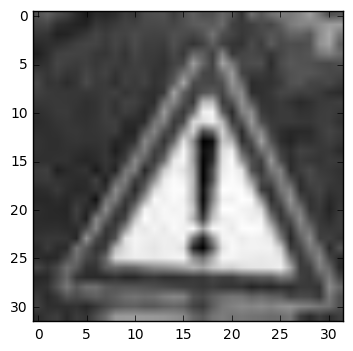

In [38]:
# Now convert the images to YUV color space then normalize them 
resized_images_data_processed = [normalize_image(rgb2yuv(image_data)) for image_data in resized_images_data]

# take a look at the Y channel, looks pretty good
plt.imshow(resized_images_data_processed[0][0][:,:,0], cmap='gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I have used 7 signs:
    1. danger
    2. 80 speed limit
    3. slippery road
    4. stop
    5. 30 speed limit
    6. forward
    7. roundabout

I believe that this will be quite an easy classification for my model as the pictures are quite clear. The only one that might cause a problem is the 30 speed limit sign, due to the glare.

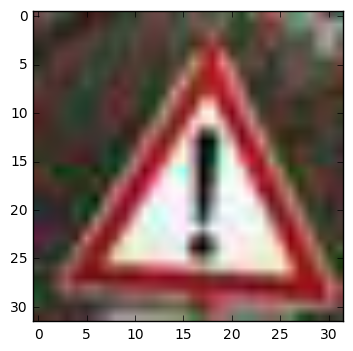

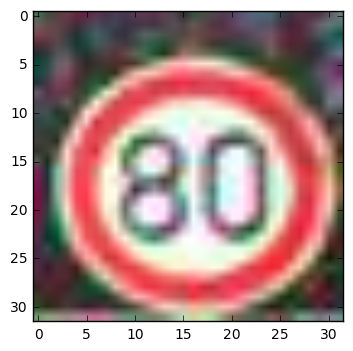

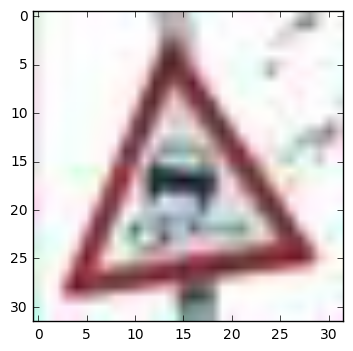

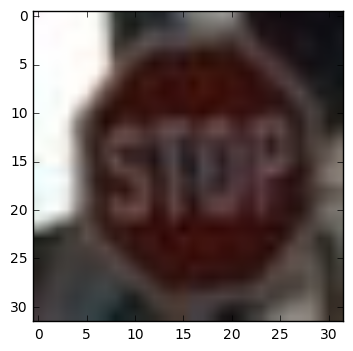

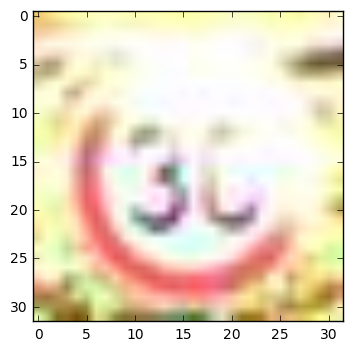

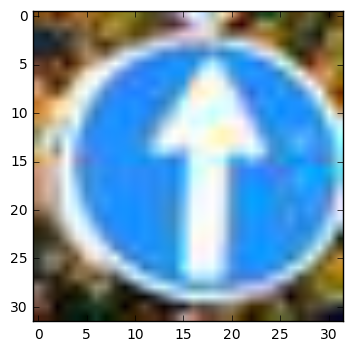

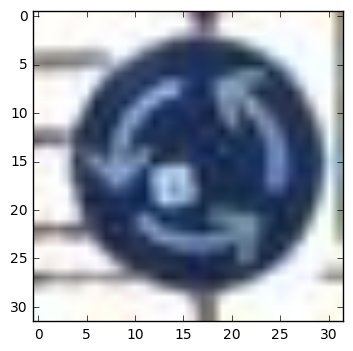

In [39]:
# Plot the images
for image_data in resized_images_data:
    plt.figure()
    plt.imshow(image_data[0])

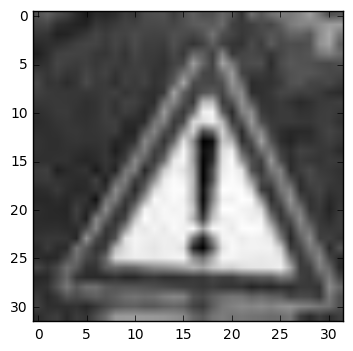

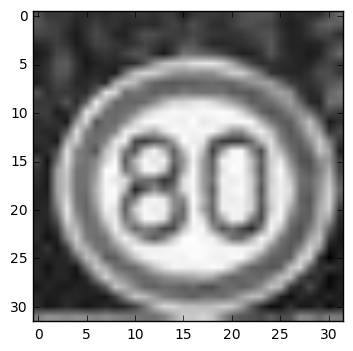

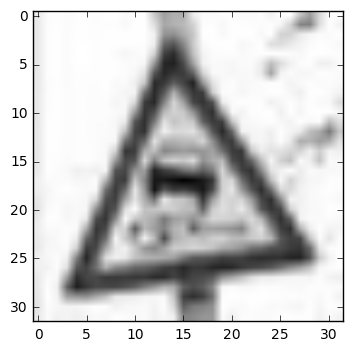

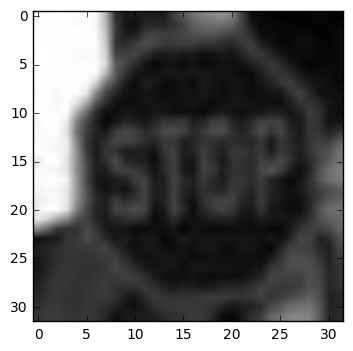

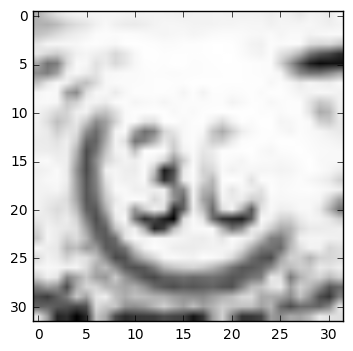

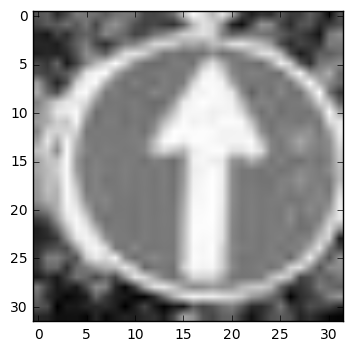

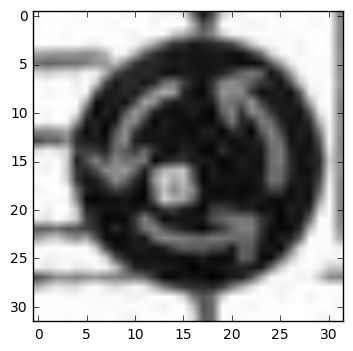

In [40]:
for image_data in resized_images_data_processed:
    plt.figure()
    plt.imshow(image_data[0][:,:,0], cmap = "gray")

In [41]:
# Do the prediction 
predictions = []
with tf.Session() as sess:
    saver.restore(sess, SAVE_FILE)
    for image_data in resized_images_data_processed:
        prediction = sess.run(tf.argmax(logits,1), feed_dict = {x: image_data, keep_prob: 1})
        predictions.append(prediction)
print(predictions)

[array([18]), array([5]), array([23]), array([8]), array([1]), array([35]), array([40])]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
    I have used 7 signs:
    1. general caution ✓
    2. 80 speed limit ✓
    3. slippery road ✓
    4. stop ✗ speed limit 120 km/h
    5. 30 speed limit ✓
    6. ahead only ✓
    7. roundabout ✓
    
The model reached an accuracy of 6/7

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
It seems that my model is very certain (in fact 100% certain) about its classifications.

In [42]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, SAVE_FILE)
    for image_data in resized_images_data:
        top_3_predictions = sess.run(tf.nn.top_k(softmax, k=3), feed_dict = {x: image_data, keep_prob : 1})
        print(top_3_predictions)

        

TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[10,  0,  1]], dtype=int32))
TopKV2(values=array([[  1.00000000e+00,   6.04177080e-25,   4.30945351e-31]], dtype=float32), indices=array([[36, 18,  4]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[18,  0,  1]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[42,  0,  1]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[18,  0,  1]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[17,  0,  1]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[1, 0, 2]], dtype=int32))
